In [1]:
%matplotlib inline
import os
import re
from collections import defaultdict
from typing import Dict, List, Tuple
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
# 中文注释：解析单个结果文件，返回(method, time_seconds, max_component)
def parse_result_file(file_path: str) -> Tuple[str, float, int]:
    method = None
    time_seconds = None
    max_component = None
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for _ in range(20):
                line = f.readline()
                if not line:
                    break
                line = line.strip()
                if not line.startswith('#'):
                    break
                if '求解方法' in line:
                    m = re.search(r':\s*(.+)$', line)
                    if m:
                        method = m.group(1).strip()
                elif '最大连通子图大小' in line:
                    m = re.search(r':\s*([0-9]+)', line)
                    if m:
                        try:
                            max_component = int(m.group(1))
                        except ValueError:
                            pass
                elif '求解时间' in line:
                    m = re.search(r':\s*([0-9]+(?:\.[0-9]+)?)', line)
                    if m:
                        try:
                            time_seconds = float(m.group(1))
                        except ValueError:
                            pass
    except Exception:
        pass
    file_name = os.path.basename(file_path)
    m_name = re.match(r'(.+?)-([0-9]+)_cut_edges\.txt$', file_name)
    if m_name:
        if method is None:
            method = m_name.group(1)
        if max_component is None:
            try:
                max_component = int(m_name.group(2))
            except ValueError:
                pass
    else:
        m_name2 = re.match(r'(.+?)_cut_edges\.txt$', file_name)
        if m_name2 and method is None:
            method = m_name2.group(1)
    return method, time_seconds, max_component



In [2]:
# 中文注释：聚合函数和一些绘图公用工具
def aggregate_results(results_root: str, N: int, E: int, allow_methods: List[str] = None, selected_networks: List[str] = None) -> Dict[str, Dict[str, List[float]]]:
    """
    聚合指定 N,E 下所有 S 的方法统计信息。
    selected_networks: 可选列表，包含要包含的子目录名或子串（例如 ['S1','N200_E300_S88']）。
    """
    agg: Dict[str, Dict[str, List[float]]] = defaultdict(lambda: {"time": [], "quality": [], "efficiency": []})
    target_prefix = f"N{N}_E{E}_S"
    if not os.path.isdir(results_root):
        raise FileNotFoundError(f"Results directory not found: {results_root}")
    base_quality = N
    for entry in os.listdir(results_root):
        if not entry.startswith(target_prefix):
            continue
        # 如果传入 selected_networks，则只包含匹配的子目录
        if selected_networks is not None and len(selected_networks) > 0:
            matched = False
            for sel in selected_networks:
                if sel == entry or sel in entry:
                    matched = True
                    break
            if not matched:
                continue
        subdir = os.path.join(results_root, entry)
        if not os.path.isdir(subdir):
            continue
        for fname in os.listdir(subdir):
            if not fname.endswith('_cut_edges.txt'):
                continue
            fpath = os.path.join(subdir, fname)
            method, t_sec, q_val = parse_result_file(fpath)
            if not method:
                continue
            if allow_methods is not None and len(allow_methods) > 0:
                if method not in allow_methods:
                    continue
            if t_sec is not None:
                agg[method]["time"].append(t_sec)
            if q_val is not None:
                q = float(q_val)
                agg[method]["quality"].append(q)
                if t_sec is not None and t_sec > 0:
                    eff = max(base_quality - q, 0.0) / t_sec
                    agg[method]["efficiency"].append(eff)
    return agg


def aggregate_overall_by_NE(results_root: str, allow_methods: List[str] = None):
    ne_to_method_vals = {}
    if not os.path.isdir(results_root):
        return [], [], {"time": {}, "quality": {}, "efficiency": {}}
    for entry in os.listdir(results_root):
        m = re.match(r'^N(\d+)_E(\d+)_S(\d+)$', entry)
        if not m:
            continue
        N_val = int(m.group(1))
        E_val = int(m.group(2))
        subdir = os.path.join(results_root, entry)
        if not os.path.isdir(subdir):
            continue
        for fname in os.listdir(subdir):
            if not fname.endswith('_cut_edges.txt'):
                continue
            fpath = os.path.join(subdir, fname)
            method, t_sec, q_val = parse_result_file(fpath)
            if not method:
                continue
            if allow_methods is not None and len(allow_methods) > 0 and method not in allow_methods:
                continue
            key = (N_val, E_val)
            if key not in ne_to_method_vals:
                ne_to_method_vals[key] = {}
            if method not in ne_to_method_vals[key]:
                ne_to_method_vals[key][method] = {"time": [], "quality": [], "efficiency": []}
            if t_sec is not None:
                ne_to_method_vals[key][method]["time"].append(t_sec)
            if q_val is not None:
                q = float(q_val)
                ne_to_method_vals[key][method]["quality"].append(q)
                if t_sec is not None and t_sec > 0:
                    eff = max(N_val - q, 0.0) / t_sec
                    ne_to_method_vals[key][method]["efficiency"].append(eff)
    ne_keys = sorted(list(ne_to_method_vals.keys()), key=lambda x: (x[0], x[1]))
    ne_labels = [f'N{n}_E{e}' for n, e in ne_keys]
    method_set = set()
    for key in ne_keys:
        method_set.update(ne_to_method_vals[key].keys())
    methods_sorted = sorted(method_set) if (allow_methods is None or len(allow_methods) == 0) else [m for m in allow_methods if m in method_set]
    metrics = {"time": {}, "quality": {}, "efficiency": {}}
    for method in methods_sorted:
        for metric in metrics.keys():
            series = []
            for key in ne_keys:
                vals = ne_to_method_vals.get(key, {}).get(method, {}).get(metric, [])
                if len(vals) == 0:
                    series.append(float('nan'))
                else:
                    series.append(sum(vals) / len(vals))
            metrics[metric][method] = series
    return ne_labels, methods_sorted, metrics

# 中文注释：绘图风格与通用工具
def set_nature_rcparams():
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except Exception:
        try:
            plt.style.use('seaborn-whitegrid')
        except Exception:
            pass
    mpl.rcParams.update({
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'font.size': 8,
        'axes.titlesize': 9,
        'axes.labelsize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'axes.linewidth': 0.8,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'grid.linewidth': 0.5,
        'grid.alpha': 0.15,
        'pdf.fonttype': 42,
        'ps.fonttype': 42,
    })

def beautify_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.15)
    ax.grid(axis='x', visible=False)

def dynamic_figsize(n_items: int, base: float = 3.5, per_item: float = 0.18, max_w: float = 7.2, h: float = 2.6) -> Tuple[float, float]:
    w = per_item * max(n_items, 1) + (base - 1.5)
    w = min(max(w, base), max_w)
    return (w, h)

palette = [
    '#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B2',
    '#937860', '#DA8BC3', '#8C8C8C', '#64B5CD', '#4E9F50',
]

def format_value(v: float) -> str:
    try:
        return f"{float(v):.3g}"
    except Exception:
        return str(v)

def add_bar_labels(ax, rects):
    y_min, y_max = ax.get_ylim()
    y_off = max(1e-12, (y_max - y_min) * 0.015)
    for r in rects:
        h = r.get_height()
        ax.text(r.get_x() + r.get_width() / 2.0, h + y_off, format_value(h), ha='center', va='bottom', fontsize=7)



In [3]:
# 中文注释：将每个图的绘制拆成单独函数，单元格中调用以生成单张图像并显示
from IPython.display import Image, display

def plot_avg_time(agg, out_dir, N, E):
    methods = sorted(agg.keys())
    time_methods = [m for m in methods if len(agg[m]["time"]) > 0]
    if len(time_methods) == 0:
        print('No time data to plot')
        return
    avg_times = [sum(agg[m]["time"]) / len(agg[m]["time"]) for m in time_methods]
    set_nature_rcparams()
    fig_w, fig_h = dynamic_figsize(len(time_methods), h=2.4)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    color_map = {m: palette[i % len(palette)] for i, m in enumerate(time_methods)}
    colors = [color_map[m] for m in time_methods]
    x = list(range(len(time_methods)))
    bars = ax.bar(x, avg_times, color=colors, edgecolor='none')
    ax.set_ylabel('Average Solve Time (s)')
    ax.set_xlabel('Method')
    ax.set_title(f'Average Solve Time by Method (N={N}, E={E})')
    ax.set_xticks(x)
    ax.set_xticklabels(time_methods, rotation=30, ha='right')
    beautify_axes(ax)
    add_bar_labels(ax, bars)
    fig.tight_layout()
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, 'avg_time.png')
    fig.savefig(out_path)
    plt.close(fig)
    display(Image(filename=out_path))

def plot_avg_quality(agg, out_dir, N, E):
    methods = sorted(agg.keys())
    qual_methods = [m for m in methods if len(agg[m]["quality"]) > 0]
    if len(qual_methods) == 0:
        print('No quality data to plot')
        return
    avg_quals = [sum(agg[m]["quality"]) / len(agg[m]["quality"]) for m in qual_methods]
    set_nature_rcparams()
    fig_w, fig_h = dynamic_figsize(len(qual_methods), h=2.4)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    color_map = {m: palette[i % len(palette)] for i, m in enumerate(qual_methods)}
    colors = [color_map[m] for m in qual_methods]
    x = list(range(len(qual_methods)))
    bars = ax.bar(x, avg_quals, color=colors, edgecolor='none')
    ax.set_ylabel('Average Max Component Size (smaller is better)')
    ax.set_xlabel('Method')
    ax.set_title(f'Average Quality by Method (N={N}, E={E})')
    ax.set_xticks(x)
    ax.set_xticklabels(qual_methods, rotation=30, ha='right')
    beautify_axes(ax)
    add_bar_labels(ax, bars)
    fig.tight_layout()
    out_path = os.path.join(out_dir, 'avg_quality.png')
    fig.savefig(out_path)
    plt.close(fig)
    display(Image(filename=out_path))

def plot_avg_efficiency(agg, out_dir, N, E):
    methods = sorted(agg.keys())
    eff_methods = [m for m in methods if len(agg[m]["efficiency"]) > 0]
    if len(eff_methods) == 0:
        print('No efficiency data to plot')
        return
    avg_effs = [sum(agg[m]["efficiency"]) / len(agg[m]["efficiency"]) for m in eff_methods]
    set_nature_rcparams()
    fig_w, fig_h = dynamic_figsize(len(eff_methods), h=2.4)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    color_map = {m: palette[i % len(palette)] for i, m in enumerate(eff_methods)}
    colors = [color_map[m] for m in eff_methods]
    x = list(range(len(eff_methods)))
    bars = ax.bar(x, avg_effs, color=colors, edgecolor='none')
    ax.set_ylabel('Average Efficiency (quality/time, lower is better)')
    ax.set_xlabel('Method')
    ax.set_title(f'Average Efficiency by Method (N={N}, E={E})')
    ax.set_xticks(x)
    ax.set_xticklabels(eff_methods, rotation=30, ha='right')
    beautify_axes(ax)
    add_bar_labels(ax, bars)
    fig.tight_layout()
    out_path = os.path.join(out_dir, 'avg_efficiency.png')
    fig.savefig(out_path)
    plt.close(fig)
    display(Image(filename=out_path))

def plot_time_vs_quality(agg, out_dir, N, E):
    scatter_methods = [m for m in sorted(agg.keys()) if len(agg[m]["time"]) > 0 and len(agg[m]["quality"]) > 0]
    if len(scatter_methods) == 0:
        print('No data for time vs quality scatter')
        return
    s_times = [sum(agg[m]["time"]) / len(agg[m]["time"]) for m in scatter_methods]
    s_quals = [sum(agg[m]["quality"]) / len(agg[m]["quality"]) for m in scatter_methods]
    set_nature_rcparams()
    fig, ax = plt.subplots(figsize=(3.5, 2.8))
    color_map = {m: palette[i % len(palette)] for i, m in enumerate(scatter_methods)}
    colors = [color_map[m] for m in scatter_methods]
    ax.scatter(s_times, s_quals, c=colors, s=24, linewidths=0.5, edgecolors='white')
    for xv, yv, label, c in zip(s_times, s_quals, scatter_methods, colors):
        ax.annotate(f"{label}: t={format_value(xv)}, q={format_value(yv)}", (xv, yv), textcoords="offset points", xytext=(6, 6), fontsize=7, color=c)
    ax.set_xlabel('Average Solve Time (s)')
    ax.set_ylabel('Average Max Component Size (smaller is better)')
    ax.set_title(f'Time vs Quality (N={N}, E={E})')
    beautify_axes(ax)
    ax.grid(alpha=0.15)
    fig.tight_layout()
    out_path = os.path.join(out_dir, 'time_vs_quality.png')
    fig.savefig(out_path)
    plt.close(fig)
    display(Image(filename=out_path))


In [4]:
# 中文注释：整体 NE 比较——单独绘制某一指标的函数
def plot_overall_metric(results_root: str, figs_root: str, metric: str, allow_methods: List[str] = None):
    out_dir = os.path.join(figs_root, 'overall')
    os.makedirs(out_dir, exist_ok=True)
    ne_labels, methods_sorted, metrics = aggregate_overall_by_NE(results_root, allow_methods)
    if len(ne_labels) == 0 or len(methods_sorted) == 0:
        print(f'Overall {metric} skipped: no data')
        return
    color_map = {m: palette[i % len(palette)] for i, m in enumerate(methods_sorted)}
    x_ticks = list(range(len(ne_labels)))
    fig_w, fig_h = (max(3.5, 0.12 * len(ne_labels)), 2.6)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    m_count = max(1, len(methods_sorted))
    group_w = 0.82
    bar_w = min(group_w / m_count, 0.28)
    start = - (m_count - 1) * bar_w / 2.0
    for i, m in enumerate(methods_sorted):
        y_vals = metrics.get(metric, {}).get(m, [])
        x_pos = [xt + (start + i * bar_w) for xt in x_ticks]
        y_plot = [0.0 if (yv != yv) else yv for yv in y_vals]
        bars = ax.bar(x_pos, y_plot, width=bar_w, label=m, color=color_map[m], alpha=0.9, edgecolor='none')
    ax.set_xlabel('Dataset (N,E)')
    ylabel_map = {
        'time': 'Solve Time (s)',
        'quality': 'Max Component Size (smaller is better)',
        'efficiency': 'Efficiency ((N - max_component)/time, higher is better)'
    }
    ax.set_ylabel(ylabel_map.get(metric, metric))
    ax.set_title(f'Overall {metric.capitalize()} across N,E')
    beautify_axes(ax)
    ax.legend(ncol=2, frameon=False)
    fig.tight_layout()
    out_path = os.path.join(out_dir, f'overall_{metric}.png')
    fig.savefig(out_path)
    plt.close(fig)
    display(Image(filename=out_path))


In [14]:
allow_methods = ['greedy-s3', 'mealpy-de', 'mealpy-pso', 'mealpy-gwo', 'mealpy-ga', 'mealpy-woa', 'gurobi']

In [15]:
# 中文注释：参数设置并计算聚合结果（可在笔记本中修改 N/E/目录/网络/方法后重新运行）
N = 200
E = 300
results_root = os.path.abspath('results')
figs_root = os.path.abspath('figs')
# **可编辑**：选择要参与绘图的网络子目录（可填子目录完整名或其子串），空列表或 None 表示包含所有匹配的 S
selected_networks = None  # e.g. ['S88', 'S5'] or ['N200_E300_S88']
# **可编辑**：选择要包含的方法列表（可多选），空列表或 None 表示包含所有方法
agg = aggregate_results(results_root, N, E, allow_methods, selected_networks)
out_dir = os.path.join(figs_root, f'N{N}_E{E}')
os.makedirs(out_dir, exist_ok=True)
print(f'Computed aggregates for N={N}, E={E}, selected_networks={selected_networks}, methods={allow_methods}, output dir: {out_dir}')



Computed aggregates for N=200, E=300, selected_networks=None, methods=['greedy-s3', 'mealpy-de', 'mealpy-pso', 'mealpy-gwo', 'mealpy-ga', 'mealpy-woa', 'gurobi'], output dir: /home/suruixian/Documents/Homework/figs/N200_E300


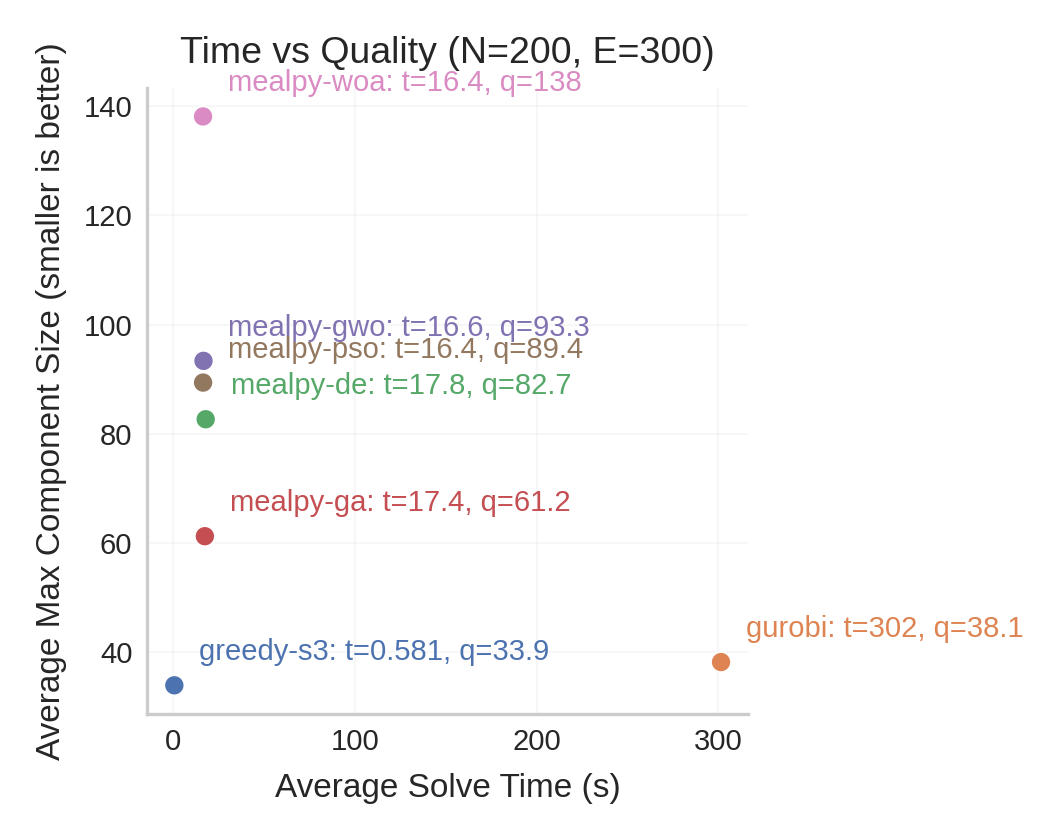

In [16]:
# 单元格：绘制并显示 Time vs Quality 散点图
from IPython.display import Image, display
scatter_methods = [m for m in sorted(agg.keys()) if len(agg[m]["time"]) > 0 and len(agg[m]["quality"]) > 0]
if len(scatter_methods) == 0:
    print('No data for time vs quality scatter')
else:
    s_times = [sum(agg[m]["time"]) / len(agg[m]["time"]) for m in scatter_methods]
    s_quals = [sum(agg[m]["quality"]) / len(agg[m]["quality"]) for m in scatter_methods]
    set_nature_rcparams()
    fig, ax = plt.subplots(figsize=(3.5, 2.8))
    color_map = {m: palette[i % len(palette)] for i, m in enumerate(scatter_methods)}
    colors = [color_map[m] for m in scatter_methods]
    ax.scatter(s_times, s_quals, c=colors, s=24, linewidths=0.5, edgecolors='white')
    for xv, yv, label, c in zip(s_times, s_quals, scatter_methods, colors):
        ax.annotate(f"{label}: t={format_value(xv)}, q={format_value(yv)}", (xv, yv), textcoords="offset points", xytext=(6, 6), fontsize=7, color=c)
    ax.set_xlabel('Average Solve Time (s)')
    ax.set_ylabel('Average Max Component Size (smaller is better)')
    ax.set_title(f'Time vs Quality (N={N}, E={E})')
    beautify_axes(ax)
    ax.grid(alpha=0.15)
    fig.tight_layout()
    out_path = os.path.join(out_dir, 'time_vs_quality.png')
    fig.savefig(out_path)
    plt.close(fig)
    display(Image(filename=out_path))



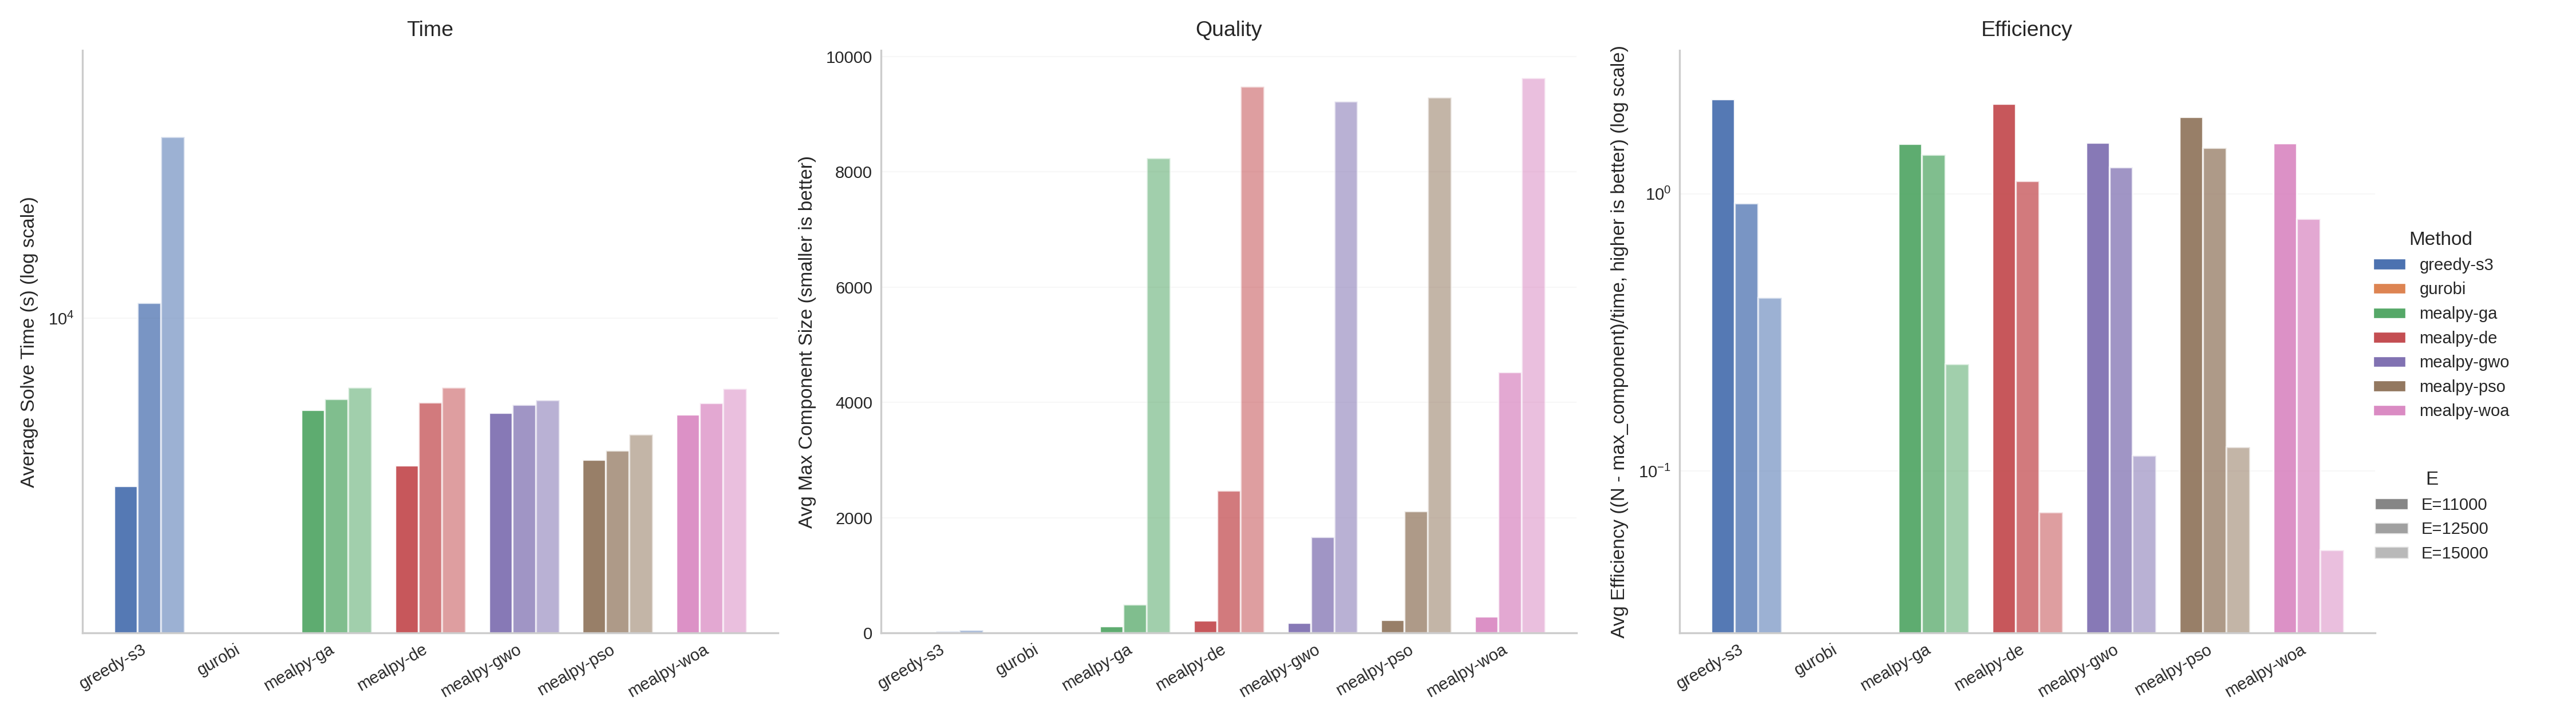

In [45]:
# 新单元：在一张图中比较 N=200 时 E=300,400,500 的 time/quality/efficiency（分三列）
# E_list = [300, 400, 500]
# N = 200
E_list = [11000,12500,15000]
N=10000
selected_Es = E_list
method_set = set()
per_E_agg = {}
for E_val in selected_Es:
    agg_e = aggregate_results(results_root, N, E_val, allow_methods, selected_networks)
    per_E_agg[E_val] = agg_e
    method_set.update(agg_e.keys())
# 如果在指定方法列表中但数据集中没有出现，也把它们包含进来以保持顺序
if allow_methods is not None and len(allow_methods) > 0:
    for m in allow_methods:
        method_set.add(m)

# 自定义排序：将 Greedy、Gurobi、GA 放在前三个位置
priority_methods = ['greedy-s3', 'gurobi', 'mealpy-ga']
def sort_methods(m):
    """排序函数：优先方法排在前面，其他按字母顺序"""
    if m in priority_methods:
        return (0, priority_methods.index(m))
    else:
        return (1, m)  # 其他方法按字母顺序排在后面

methods_sorted = sorted(method_set, key=sort_methods)
if len(methods_sorted) == 0:
    print('No methods found for the specified N/E combinations')
else:
    # 计算每个 E 每个方法的平均指标值（若无则为 nan）
    metrics_names = ['time', 'quality', 'efficiency']
    metric_avgs = {mname: {E_val: [] for E_val in selected_Es} for mname in metrics_names}
    for m in methods_sorted:
        for E_val in selected_Es:
            agg = per_E_agg.get(E_val, {})
            vals_time = agg.get(m, {}).get('time', [])
            vals_q = agg.get(m, {}).get('quality', [])
            vals_eff = agg.get(m, {}).get('efficiency', [])
            metric_avgs['time'][E_val].append(sum(vals_time)/len(vals_time) if vals_time else float('nan'))
            metric_avgs['quality'][E_val].append(sum(vals_q)/len(vals_q) if vals_q else float('nan'))
            metric_avgs['efficiency'][E_val].append(sum(vals_eff)/len(vals_eff) if vals_eff else float('nan'))

    set_nature_rcparams()
    n_methods = len(methods_sorted)
    # 每种方法一种颜色
    color_map_method = {m: palette[i % len(palette)] for i, m in enumerate(methods_sorted)}
    # 为每个E值使用不同的透明度来区分，但保持方法颜色
    alpha_values = [0.95, 0.75, 0.55]  # E=300最不透明，E=500最透明

    # 增大图像宽度
    fig_w = max(15.0, n_methods * 0.4 + 8.0)  # 更宽的图像
    fig_h = 4.2  # 稍微增加高度
    fig, axs = plt.subplots(1, 3, figsize=(fig_w, fig_h))
    x = list(range(n_methods))
    group_w = 0.75
    n_groups = len(selected_Es)
    bar_w = min(group_w / n_groups, 0.25)
    start = - (n_groups - 1) * bar_w / 2.0
    ylabel_map = {
        'time': 'Average Solve Time (s)',
        'quality': 'Avg Max Component Size (smaller is better)',
        'efficiency': 'Avg Efficiency ((N - max_component)/time, higher is better)'
    }
    # 需要对数刻度的指标（数值范围差异大）
    log_scale_metrics = ['time', 'efficiency']

    for ax_idx, metric in enumerate(metrics_names):
        ax = axs[ax_idx]
        
        # 收集所有非NaN值用于确定y轴范围
        all_values = []
        for im, m in enumerate(methods_sorted):
            for iE, E_val in enumerate(selected_Es):
                y = metric_avgs[metric][E_val][im]
                if not (y != y):  # 检查非NaN
                    if y > 0:
                        all_values.append(y)
        
        for im, m in enumerate(methods_sorted):
            for iE, E_val in enumerate(selected_Es):
                y = metric_avgs[metric][E_val][im]
                x_pos = im + (start + iE * bar_w)
                # 方法颜色，E值用透明度区分
                # 对于对数刻度，确保值大于0（或设为很小的正值）
                if metric in log_scale_metrics:
                    y_plot = max(y, 0.01) if (y != y or y <= 0) else y  # NaN或<=0的值设为0.01
                else:
                    y_plot = 0 if (y != y) else y
                ax.bar(x_pos, y_plot, width=bar_w, color=color_map_method[m], 
                       edgecolor='white', linewidth=0.8, alpha=alpha_values[iE])
        
        # 设置对数刻度
        if metric in log_scale_metrics:
            if len(all_values) > 0:
                min_val = min(all_values)
                max_val = max(all_values)
                # 设置对数刻度，并确保有合理的最小值
                ax.set_yscale('log')
                ax.set_ylim(bottom=max(0.01, min_val * 0.5), top=max_val * 1.5)
                # 更新y轴标签
                ax.set_ylabel(ylabel_map.get(metric, '') + ' (log scale)')
            else:
                ax.set_ylabel(ylabel_map.get(metric, ''))
        else:
            ax.set_ylabel(ylabel_map.get(metric, ''))
        
        ax.set_xticks(x)
        ax.set_xticklabels(methods_sorted, rotation=30, ha='right')
        ax.set_title(metric.capitalize())
        beautify_axes(ax)

    # 构建图例：方法颜色（方法）和透明度（E）
    method_handles = [mpl.patches.Patch(facecolor=color_map_method[m], edgecolor='white', 
                                        linewidth=0.8, label=m) for m in methods_sorted]
    e_handles = [mpl.patches.Patch(facecolor='gray', edgecolor='white', 
                                   linewidth=0.8, alpha=alpha_values[i], label=f'E={selected_Es[i]}') 
                for i in range(len(selected_Es))]
    
    # 优化图例位置：放在整个图形的右侧，更紧凑
    # 先调整布局，为图例留出空间（减少预留空间）
    fig.tight_layout(rect=[0, 0, 0.93, 1])  # 右侧留出10%空间给图例
    
    # 将方法图例放在整体右侧上部，更靠近绘图区域
    legend_methods = fig.legend(handles=method_handles, title='Method', 
                                bbox_to_anchor=(0.98, 0.7), loc='upper right', 
                                frameon=False, fontsize=7, ncol=1)
    # 将 E 的图例放在整体右侧下部，更靠近绘图区域
    legend_E = fig.legend(handles=e_handles, title='E', 
                         bbox_to_anchor=(0.972, 0.2), loc='lower right', 
                         frameon=False, fontsize=7, ncol=1)
    out_dir_multi = os.path.join(figs_root, f'N{N}_E_multiple')
    os.makedirs(out_dir_multi, exist_ok=True)
    out_path = os.path.join(out_dir_multi, 'N200_Es_300_400_500_metrics.png')
    fig.savefig(out_path)
    plt.close(fig)
    display(Image(filename=out_path))

